In [5]:
import torch
import torch.nn as nn
import torchvision

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# check GPU availability

In [4]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [93]:
class ConvNet(nn.Module):
    def __init__(self, num_class = 10):
        super(ConvNet, self).__init__()
        # 30x30
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=5, stride = 1, padding = 2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride = 1, padding = 2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        nn.Sigmoid())
        
        self.fc = nn.Linear(7*7*32, num_class)
        
    def forward(self, x, feature):
        main_out = self.layer1(x)
        feat_out = self.layer1(feature)
        main_out = torch.cat((main_out, feat_out))
        print(main_out.shape)
        main_out = self.layer2(main_out)
        main_out = main_out.reshape(main_out.size(0),-1)
        main_out = self.fc(main_out)
        return main_out
    
model = ConvNet(10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [62]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sigmoid()
  )
)

In [25]:
DATASET_PATH = 'uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_10k_train_v2.hdf5'

with h5py.File(DATASET_PATH, 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [26]:
print(train_data.keys())

dict_keys(['datetime', 'land_cover', 'latitude', 'longitude', 'meteorology', 'observed', 'target'])


In [27]:
large_fire_inds = np.where(
    (np.sum(train_data['observed'][:,0],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,1],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,2],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,3],axis=(1,2)) > 50) & 
    (np.sum(train_data['observed'][:,4],axis=(1,2)) > 50) & 
    (np.sum(train_data['target'][:,0],axis=(1,2)) > 50) 
)[0]

In [28]:
TRAINING_POINT = large_fire_inds[0]

In [29]:
LAND_COVER_LAYER_NAME_TO_IND = {'ASP': 0, 'CBD': 1, 'CBH': 2, 'CC': 3, 'CH': 4, 'DEM': 5, 'EVT': 6, 'SLP': 16}
VEGETATION_NAME_TO_IND = {'Nodata': 0, 'Sparse': 1, 'Tree': 2, 'Shrub': 3, 'Herb': 4, 'Water': 5, 'Barren': 6, 'Developed': 7, 'Snow-Ice': 8, 'Agriculture': 9}

TOPO_NAMES = ['ASP', 'SLP', 'DEM']
VEG_NAME = 'EVT'
FUEL_NAMES = ['CBD', 'CBH', 'CC', 'CH']

In [36]:
image1 = train_data['observed'][TRAINING_POINT]
feature = train_data['land_cover'][TRAINING_POINT][LAND_COVER_LAYER_NAME_TO_IND["ASP"]]

In [59]:

temp = torch.from_numpy(image1[0])
temp2 = temp[None, None,:,:]
temp2.shape



torch.Size([1, 1, 30, 30])

In [60]:
temp = torch.from_numpy(feature)
tempf = temp[None,None,:,:]
tempf.shape

torch.Size([1, 1, 30, 30])

In [94]:
output = model(temp2.float(), tempf.float())

torch.Size([2, 16, 15, 15])


In [96]:
output

tensor([[-0.2303, -0.8195,  0.0361,  0.1536,  0.6410, -0.1525,  0.3302,  0.2008,
          0.2791,  0.1905],
        [-0.3602, -0.6657,  0.2193,  0.2471,  0.8727, -0.3682,  0.2648,  0.0827,
          0.3436,  0.0975]], grad_fn=<AddmmBackward>)

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

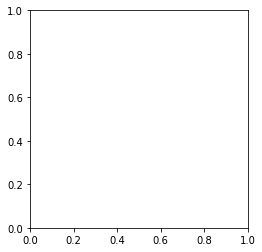

In [87]:
# plt.title(f'{-12 * (4-i)} hours')
plt.imshow(output)